# Week 3: Fast pipelines, profiling
While implementing a deep learning pipeline, you might encounter bottlenecks in different parts of you solution: from loading data from disk to model execution. During this seminar we will try to highlight key points in DL pipelines to pay attention to.

### Seminar outline
1. Faster training
    - Automatic mixed precision (AMP)
    - Tensor cores on GPU
2. Data downloading parallelism: HuggingFace streaming dataset
3. Data loading from disk: image decoders benchmarks
4. Data augmentations on GPU: Nvidia DALI
5. Data loading to GPU: efficient batching for LM
6. Profiling
    - General purpose Python profiling with `py-spy`
    - Deep learning profiling: PyTorch profiler
    - Deep learning profiling: PyTorch profiler with TensorBoard
    - Profiling with `nvprof`
    - Last but not least profiler: `torch.utils.bottleneck`

## 0. Before we start

In [30]:
# ! pip install -r requirements.txt

In [2]:
# ! nvidia-smi

## 1. Faster training
### Automatic mixed precision (AMP)
Let's use a simple MNIST training example to see the difference between full precision training, half precision training and mixed precision training.

In [3]:
import gc
from time import time
from typing import Literal

import torch
import torch.nn as nn
import torchvision
from tqdm.auto import tqdm, trange

device = torch.device("cuda:1")

In [4]:
# very standard data things
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

mnist_train = torchvision.datasets.MNIST(
    "./mnist/",
    train=True,
    download=True,
    transform=transform,
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/",
    train=False,
    download=True,
    transform=transform,
)


train_dataloader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=1024,
    shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=1024, shuffle=False)

In [5]:
# train loop is adapted for full and half precisions training modes
def train(
    model: nn.Module,
    loss_fn: nn.modules.loss,
    optimizer: torch.optim.Optimizer,
    n_epochs: int = 3,
    device: torch.device = torch.device("cuda:0"),
    precision: Literal["full", "half"] = "full",
    loss_scaling: bool = False,
) -> None:
    assert not (
        loss_scaling and precision == "half"
    ), "Cannot use standard loss scaler with FP16 model weights"

    if loss_scaling:
        scaler = torch.cuda.amp.GradScaler()
    if precision == "half":
        model.half()

    model.to(device)

    for epoch in range(n_epochs):
        model.train()
        for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch}: "):
            if precision == "half":
                x_train = x_train.half()
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)

            loss = loss_fn(y_pred, y_train)

            if loss_scaling:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            optimizer.zero_grad()

        if epoch % 2 == 0 or epoch == n_epochs - 1:
            print("Starting validation...")
            model.eval()
            val_loss = torch.empty(len(val_dataloader))
            val_accuracy = torch.empty(len(val_dataloader))

            with torch.no_grad():
                for i, (x_val, y_val) in enumerate(val_dataloader):
                    if precision == "half":
                        x_val = x_val.half()
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    y_pred = model(x_val)
                    loss = loss_fn(y_pred.float(), y_val)
                    val_loss[i] = loss
                    val_accuracy[i] = (torch.argmax(y_pred, dim=-1) == y_val).float().mean()

            print(
                f"Epoch: {epoch}, loss: {val_loss.mean().detach().cpu()}, "
                f"accuracy: {val_accuracy.mean().detach().cpu()}"
            )
    model.eval()

Firstly, let's check that full precision training converges to a reasonable accuracy score.

In [6]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Conv2d(in_channels=20, out_channels=10, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(2 * 2 * 10, 128),
    nn.ReLU(),
    nn.Linear(128, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, n_epochs=1, device=torch.device("cuda:1"))

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 0.19299419224262238, accuracy: 0.9370197057723999


Now, let's try to cast both the model and the data to half precision. Training process diverges because of the division on overflowed values in Adam.

In [7]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Conv2d(in_channels=20, out_channels=10, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(2 * 2 * 10, 128),
    nn.ReLU(),
    nn.Linear(128, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, precision="half", n_epochs=1, device=torch.device("cuda:1"))

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: nan, accuracy: 0.09818439185619354


Notice, that we can also get not `NaN`s but just a diverged process if we use another optimizer which avoids divisions. Nevertheless, we cannot achive good model quality because of the gradients underflow.

In [8]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Conv2d(in_channels=20, out_channels=10, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(2 * 2 * 10, 128),
    nn.ReLU(),
    nn.Linear(128, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, precision="half", n_epochs=3, device=torch.device("cuda:1"))

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 2.2670483589172363, accuracy: 0.17123326659202576


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 2, loss: 2.072941303253174, accuracy: 0.5418806076049805


Ok, let's get to AMP. Check out that there are two different ways how you can apply autocast to PyTorch operations.

In [9]:
# @torch.cuda.amp.autocast
# def forward_batch(x_train, y_train, model, loos_fn, device):
#     x_train, y_train = x_train.to(device), y_train.to(device)
#     y_pred = model(x_train)

#     loss = loss_fn(y_pred, y_train)


def train(
    model: nn.Module,
    loss_fn: nn.modules.loss,
    optimizer: torch.optim.Optimizer,
    n_epochs: int = 3,
    device: torch.device = torch.device("cuda:0"),
) -> None:
    scaler = torch.cuda.amp.GradScaler()
    model.to(device)

    for epoch in range(n_epochs):
        model.train()
        # it fails in this case. why?
        # with torch.cuda.amp.autocast():
        for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch}: "):
            with torch.cuda.amp.autocast():
                x_train, y_train = x_train.to(device), y_train.to(device)
                y_pred = model(x_train)

                loss = loss_fn(y_pred, y_train)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        if epoch % 2 == 0 or epoch == n_epochs - 1:
            print("Starting validation...")
            model.eval()
            val_loss = torch.empty(len(val_dataloader))
            val_accuracy = torch.empty(len(val_dataloader))

            with torch.no_grad():
                for i, (x_val, y_val) in enumerate(val_dataloader):
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    y_pred = model(x_val)
                    loss = loss_fn(y_pred, y_val)
                    val_loss[i] = loss
                    val_accuracy[i] = (torch.argmax(y_pred, dim=-1) == y_val).float().mean()

            print(
                f"Epoch: {epoch}, loss: {val_loss.mean().detach().cpu()}, "
                f"accuracy: {val_accuracy.mean().detach().cpu()}"
            )
    model.eval()


model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Conv2d(in_channels=20, out_channels=10, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(2 * 2 * 10, 128),
    nn.ReLU(),
    nn.Linear(128, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, device=torch.device("cuda:1"))

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 0.12986716628074646, accuracy: 0.9592514038085938


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 2, loss: 0.08686522394418716, accuracy: 0.9724330902099609


Computation time doesn't differ between all these versions because V100 GPU is too powerful for the task: we have a CPU bottleneck which consumes most of the time.

Note: the original model weights are always in full precision. However, under the hood, there is also a FP16 copy of the model, thus fast gradients computation can be done.

In [10]:
model[0].weight.dtype

torch.float32

In this section we will briefly examine time and memory consumption of full, half and mixed precision modes. Actually, the results are pretty much expectable.

In [11]:
# Timing utilities
start_time = None


def start_timer():
    global start_time
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.synchronize()
    start_time = time()


def end_timer_and_print(local_msg):
    torch.cuda.synchronize()
    end_time = time()
    print("\n" + local_msg)
    print(f"Total execution time = {end_time - start_time:.3f} sec")
    print(
        f"Max memory used by tensors = {torch.cuda.max_memory_allocated() // 1_000_000} megabytes"
    )

In [12]:
def make_model(in_size: int, out_size: int, num_layers: int) -> torch.nn.Module:
    layers = []
    for _ in range(num_layers - 1):
        layers.append(torch.nn.Linear(in_size, in_size))
        layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Linear(in_size, out_size))
    return torch.nn.Sequential(*tuple(layers))

In [13]:
batch_size = 512  # Try, for example, 128, 256, 513
in_size = 4096 + 2048
out_size = 4096 + 2048
num_layers = 3
num_batches = 50
epochs = 3

# Creates data in default precision.
# The same data is used for both default and mixed precision trials below.
# You don't need to manually change inputs' dtype when enabling mixed precision.
data = [torch.randn(batch_size, in_size, device=device) for _ in range(num_batches)]
targets = [torch.randn(batch_size, out_size, device=device) for _ in range(num_batches)]

loss_fn = torch.nn.MSELoss().to(device)

In [14]:
net = make_model(in_size, out_size, num_layers).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.001)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        output = net(input)
        loss = loss_fn(output, target)
        loss.backward()
        opt.step()
        opt.zero_grad()  # set_to_none=True here can modestly improve performance
end_timer_and_print("Full precision:")

/opt/conda/envs/materials_bank_env/lib/python3.11/site-packages/torch/cuda/memory.py:303: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]


Full precision:
Total execution time = 10.576 sec
Max memory used by tensors = 0 megabytes


In [15]:
net = make_model(in_size, out_size, num_layers)
opt = torch.optim.SGD(net.parameters(), lr=0.001)
net.half().to(device)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        output = net(input.half())
        loss = loss_fn(output, target.half())
        loss.backward()
        opt.step()
        opt.zero_grad()
end_timer_and_print("Half precision:")

  0%|          | 0/3 [00:00<?, ?it/s]


Half precision:
Total execution time = 2.261 sec
Max memory used by tensors = 0 megabytes


In [16]:
net = make_model(in_size, out_size, num_layers).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.001)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        with torch.cuda.amp.autocast(enabled=True):
            output = net(input)
            # output is float16 because linear layers autocast to float16.
            assert output.dtype is torch.float16

            loss = loss_fn(output, target)
            # loss is float32 because mse_loss layers autocast to float32.
            assert loss.dtype is torch.float32

        loss.backward()
        opt.step()
        opt.zero_grad()
end_timer_and_print("Mixed precision without scaling:")

  0%|          | 0/3 [00:00<?, ?it/s]


Mixed precision without scaling:
Total execution time = 3.454 sec
Max memory used by tensors = 0 megabytes


In [17]:
net = make_model(in_size, out_size, num_layers).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.001)
scaler = torch.cuda.amp.GradScaler(enabled=True)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        with torch.cuda.amp.autocast(enabled=True):
            output = net(input)
            # output is float16 because linear layers autocast to float16.
            assert output.dtype is torch.float16

            loss = loss_fn(output, target)
            # loss is float32 because mse_loss layers autocast to float32.
            assert loss.dtype is torch.float32

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()
end_timer_and_print("Mixed precision with scaling:")

  0%|          | 0/3 [00:00<?, ?it/s]


Mixed precision with scaling:
Total execution time = 4.667 sec
Max memory used by tensors = 0 megabytes


What if we want to interact with the gradients in the original scale? Here's the example if gradients unscaling while using AMP.

In [18]:
for epoch in range(0):
    for input, target in zip(data, targets):
        with torch.cuda.amp.autocast():
            output = net(input)
            loss = loss_fn(output, target)
        scaler.scale(loss).backward()

        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(opt)

        # Since the gradients of optimizer's assigned params are now unscaled, clips as usual
        # You may use the same value for max_norm here as you would without gradient scaling
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.1)

        scaler.step(opt)
        scaler.update()
        opt.zero_grad()

### Tensor cores
One of the important constraints for tensor cores to be activated is that dimensions sizes must be divisible by 8 (for Nvidia V100 GPU). Let's check this fact. We'll run the same model on two different datasets: one is slightly bigger but satisfies constraints for tensor cores activation, another one is smaller and does not satisfy such constraints.

In [19]:
data_512 = [torch.randn(512, in_size, device=device) for _ in range(num_batches)]
targets_512 = [torch.randn(512, out_size, device=device) for _ in range(num_batches)]

data_511 = [torch.randn(511, in_size, device=device) for _ in range(num_batches)]
targets_511 = [torch.randn(511, out_size, device=device) for _ in range(num_batches)]

net = make_model(in_size, out_size, num_layers).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss().to(device)
scaler = torch.cuda.amp.GradScaler(enabled=True)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data_512, targets_512):
        with torch.cuda.amp.autocast(enabled=True):
            output = net(input)
            loss = loss_fn(output, target)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()
end_timer_and_print("Mixed precision, batch_size 512:")

net = make_model(in_size, out_size, num_layers).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss().to(device)
scaler = torch.cuda.amp.GradScaler(enabled=True)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data_511, targets_511):
        with torch.cuda.amp.autocast(enabled=True):
            output = net(input)
            loss = loss_fn(output, target)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()
end_timer_and_print("Mixed precision, batch_size 511:")

  0%|          | 0/3 [00:00<?, ?it/s]


Mixed precision, batch_size 512:
Total execution time = 4.585 sec
Max memory used by tensors = 0 megabytes


  0%|          | 0/3 [00:00<?, ?it/s]


Mixed precision, batch_size 511:
Total execution time = 4.476 sec
Max memory used by tensors = 0 megabytes


## 2. Data downloading parallelism: HuggingFace streaming dataset

What if we do not want to wait until dataset is downloaded? There might be terabytes of data. We can have a little time when an instance is available, so we do not want to spend much time waiting for training to begin. Also, we can have a restricted amount of the disk space. Happily, there are implemented solutions for [streaming datasets](https://huggingface.co/docs/datasets/dataset_streaming.html), which allow us to start training simultaneously with dataset download. This can be used either for ready-to-use datasets or as a wrapper for your own ones.

In [20]:
from datasets import load_dataset

In [21]:
dataset = load_dataset(
    "oscar",
    "unshuffled_deduplicated_en",
    split="train",
    streaming=True,
)
print(next(iter(dataset)))

{'id': 0, 'text': 'Mtendere Village was inspired by the vision of Chief Napoleon Dzombe, which he shared with John Blanchard during his first visit to Malawi. Chief Napoleon conveyed the desperate need for a program to intervene and care for the orphans and vulnerable children (OVC) in Malawi, and John committed to help.\nEstablished in honor of John & Lindy’s son, Christopher Blanchard, this particular program is very dear to the Blanchard family. Dana Blanchard, or Mama Dana as she is more commonly referred to at Mtendere, lived on site during the initial development, and she returns each summer to spend the season with her Malawian family. The heart of the program is to be His hands and feet by caring for the children at Mtendere, and meeting their spiritual, physical, academic, and emotional needs.\nMtendere Village is home to 134 children, living in 16 homes with a housemother and several brothers and sisters. This family environment is one that many of the children have never pre

In [22]:
# What to do with thing we are used to? Shuffling?
shuffled_dataset = dataset.shuffle(buffer_size=10_000, seed=42)

In [23]:
next(iter(shuffled_dataset))

{'id': 892,
 'text': 'In this role, she oversees the day-to-day operations of the agency’s motoring services divisions (Vehicle Titles & Registration, Motor Vehicles, Motor Carrier, Enforcement, Consumer Relations and the Automobile Burglary & Theft Prevention Authority) to ensure they are constantly improving and identifying opportunities to become more efficient and effective in service delivery.\nMellott came to the TxDMV from Alaska’s Division of Motor Vehicles where she most recently served as deputy executive director and acting executive director where she led a major initiative to modernize and improve the customer service experience. Previous positions at the Alaska DMV include oversight of all large field offices and leading the driver licensing program.\nMellott serves on the American Association of Motor Vehicle Administrators Unconventional Vehicle Working Group and has worked collaboratively with representatives from across the country to develop best practices for states

In [24]:
# Under the hood the dataset is sharded into many parts
print(dataset.n_shards)

670


In [25]:
# How to reshuffle data on each epoch?
shuffled_dataset.set_epoch(epoch)  # seed -> seed + epoch

You can also create splits from a shuffled dataset. Note, that since, in fact, we're dealing with `IterableDataset`, we cannot access elements by index, so `.skip()` basically iterates the requested amount of times.

In [26]:
dataset = load_dataset(
    "oscar",
    "unshuffled_deduplicated_en",
    split="train",
    streaming=True,
)
dataset_head = dataset.take(2)
print(list(dataset_head))
train_dataset = shuffled_dataset.skip(1000)
eval_dataset = shuffled_dataset.take(1000)

[{'id': 0, 'text': 'Mtendere Village was inspired by the vision of Chief Napoleon Dzombe, which he shared with John Blanchard during his first visit to Malawi. Chief Napoleon conveyed the desperate need for a program to intervene and care for the orphans and vulnerable children (OVC) in Malawi, and John committed to help.\nEstablished in honor of John & Lindy’s son, Christopher Blanchard, this particular program is very dear to the Blanchard family. Dana Blanchard, or Mama Dana as she is more commonly referred to at Mtendere, lived on site during the initial development, and she returns each summer to spend the season with her Malawian family. The heart of the program is to be His hands and feet by caring for the children at Mtendere, and meeting their spiritual, physical, academic, and emotional needs.\nMtendere Village is home to 134 children, living in 16 homes with a housemother and several brothers and sisters. This family environment is one that many of the children have never pr

## 3. Data loading from disk: image decoders benchmarks

Following the lecture, let's see how different Python libraries can be used for image decoding and compare their efficiency on several `640x640` images.

In [49]:
import inspect

import cv2
import imageio
import jpeg4py
import matplotlib.pyplot as plt
import numpy as np
import skimage
from PIL import Image

In [ ]:
# PIL -> Pillow -> Pillow-SIMD
class GetArray:
    def PIL(self, image_path: str) -> np.array:
        img = Image.open(image_path)
        img = img.convert("RGB")
        return np.asarray(img)

    def opencv(self, image_path: str) -> np.array:
        img = cv2.imread(image_path)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    def jpeg4py(self, image_path: str) -> np.array:
        return jpeg4py.JPEG(image_path).decode()

    def skimage(self, image_path: str) -> np.array:
        return skimage.io.imread(image_path, plugin="matplotlib")

    def imageio(self, image_path: str) -> np.array:
        return imageio.v2.imread(image_path)


array_getter = GetArray()
methods_pool = inspect.getmembers(array_getter, predicate=inspect.ismethod)
print("Methods pool: ", [method_name for method_name, method in methods_pool], "\n")

fig, axs = plt.subplots(1, 5, figsize=(24, 6))

for i, ax in enumerate(axs):
    ax.axis("off")
    ax.imshow(methods_pool[i][1](f"pics/{i + 1}.jpg"))
    ax.set_title(methods_pool[i][0], fontsize=18)

![image_decoding](./image_decoding.png)

Now, examine `image_loaders_benchmark.py` code, which runs image decoding with the frameworks above 2000 times and check time consumption of each algorithm.

Run `python image_loaders_benchmark.py -d pics/`.

## 4. Data augmentations on GPU: Nvidia DALI

Nvidia DALI allows to move CPU workload to GPU in some cases, which include but are not limited to data loading and data preprocessing. This might be useful if you have a CPU bottleneck in your setup.

Check out documentation [page](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/index.html) and [guideline](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/use_cases/pytorch/resnet50/pytorch-resnet50.html) for conv nets training on ImageNet with DALI. Source code from guideline: [here](https://github.com/NVIDIA/DALI/blob/c572c3f98a1cfccdcca37ba4e4538419913e54fd/docs/examples/use_cases/pytorch/resnet50/main.py).

For this seminar let's borrow augmentations demo from docs.

In [51]:
# !curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
# !sudo apt install git-lfs
# !git lfs install
# !git clone https://github.com/NVIDIA/DALI_extra.git

In [ ]:
import math
import os.path

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali import pipeline_def

test_data_root = "DALI_extra"
db_folder = os.path.join(test_data_root, "db", "lmdb")

In [30]:
augmentations = dict()

# input is sampled randomly for output pixel's neighbourhood
augmentations["erase"] = lambda images: fn.erase(
    images,
    anchor=[0.3, 0.2],
    shape=[0.5, 0.6],
    normalized_anchor=True,
    normalized_shape=True,
    axis_names="HW",
)
augmentations["slice"] = lambda images: fn.slice(
    images, rel_start=[0.3, 0.2], rel_shape=[0.5, 0.6], axis_names="HW"
)
# transforms sampling coordinates to produce wavy patterns
augmentations["water"] = lambda images: fn.water(images)
# applies fisheye distortion
augmentations["sphere"] = lambda images: fn.sphere(images)
# rotates the image, enlarging the canvas
augmentations["rotate"] = lambda images: fn.rotate(
    images, angle=30, interp_type=types.INTERP_LINEAR, fill_value=0
)
# applies affine transform
augmentations["warp_affine"] = lambda images: fn.warp_affine(
    images, matrix=[1.0, 0.8, 0.0, 0.0, 1.2, 0.0], interp_type=types.INTERP_LINEAR
)
# manipulates brightness and contrast of the image
augmentations["brightness_contrast"] = lambda images: fn.brightness_contrast(
    images, brightness=0.5, contrast=1.5
)
# Generate JPEG compression artifacts
augmentations["jpeg compression distortion"] = lambda images: fn.jpeg_compression_distortion(
    images, quality=5
)
# twists colors of the image
augmentations["hsv"] = lambda images: fn.hsv(images, hue=45.0, saturation=0.2)
# places the image on a larger canvas
augmentations["paste"] = lambda images: fn.paste(
    images, ratio=2.0, fill_value=(55, 155, 155), paste_x=0.1, paste_y=0.7
)
# param flips the image
augmentations["vertical and horizontal flip"] = lambda images: fn.flip(
    images, vertical=1, horizontal=1
)

In [31]:
@pipeline_def()
def augmentation_gallery_pipe(path):
    encoded, labels = fn.readers.caffe(path=path, random_shuffle=True)
    images = fn.decoders.image(encoded, device="mixed", output_type=types.RGB)
    return tuple([labels, images] + [aug(images) for aug in augmentations.values()])


pipe = augmentation_gallery_pipe(path=db_folder, batch_size=32, num_threads=2, device_id=0, seed=10)
pipe.build()

Examine your GPU load with `nvidia-smi` while running next cell.

In [32]:
pipe_out = pipe.run()

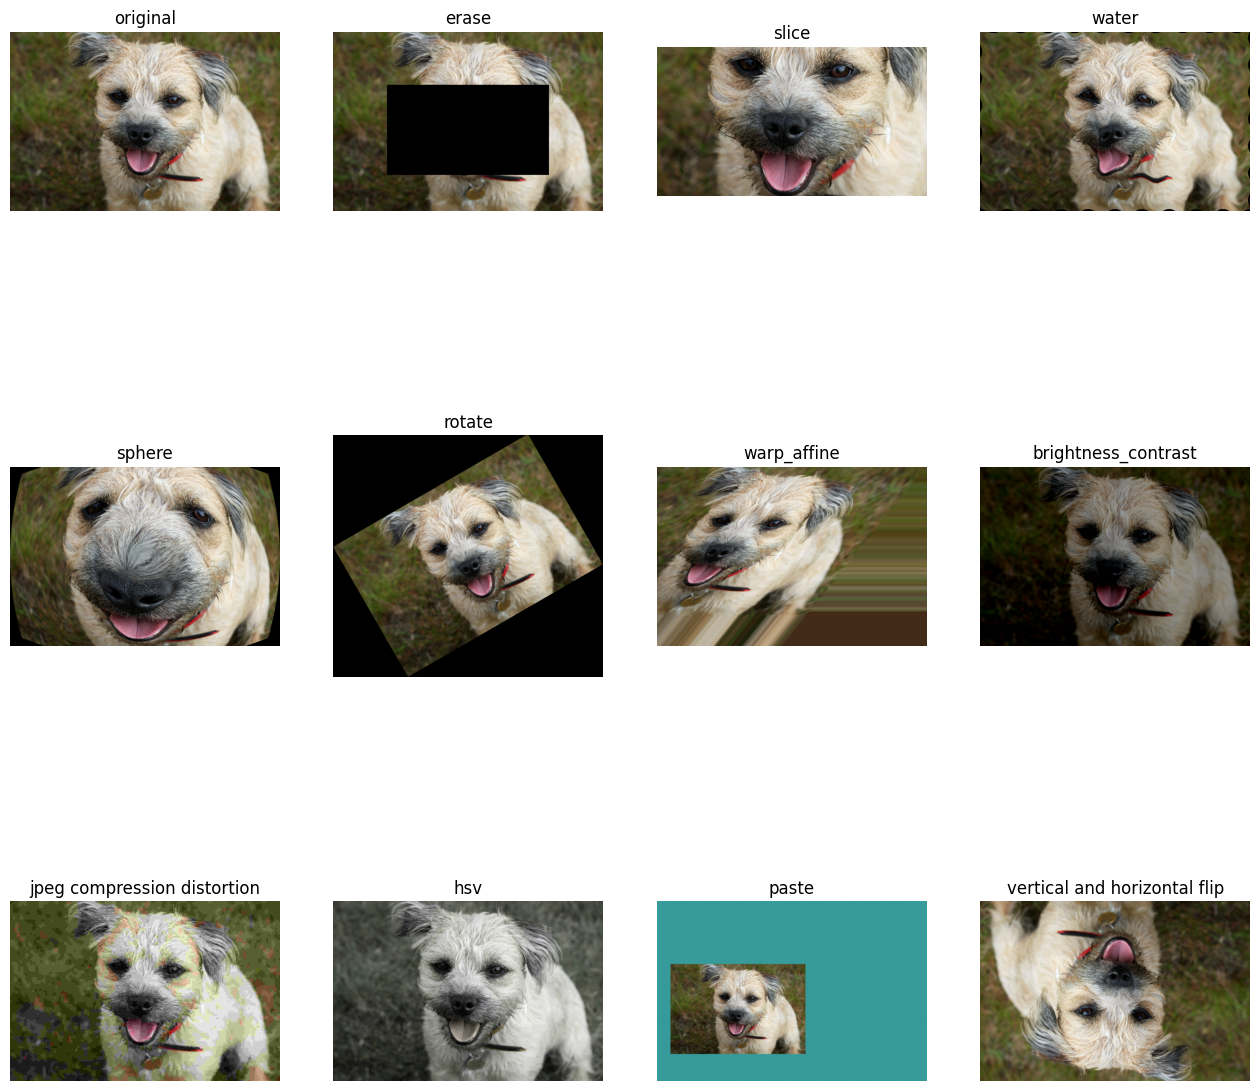

In [33]:
n = 5
len_outputs = len(pipe_out) - 1
augmentations = ["original"] + list(augmentations.keys())
fig = plt.figure(figsize=(16, 16))
columns = 4
rows = int(math.ceil(len_outputs / columns))
gs = gridspec.GridSpec(rows, columns)
for i in range(len_outputs):
    plt.subplot(gs[i])
    plt.axis("off")
    plt.title(augmentations[i])
    pipe_out_cpu = pipe_out[1 + i].as_cpu()
    img_chw = pipe_out_cpu.at(n)
    plt.imshow(img_chw / 255.0)

## 5. Data loading to GPU: efficient batching for LM

Let's recall that working with data in Pytorch is usually divided into two different entities: `torch.utils.data.Dataset` and `torch.utils.data.Dataloader`. In the class, inherited from `torch.utils.data.Dataset` you must implement three methods: `__init__` and `__getitem__` (obligatory) and `__len__` (preferably but not obligatory). However, it's `torch.utils.data.Dataloader`, which spawns different CPU workers which call dataset's `__getitem__` and combine batches for training.

Standard batching approach (default `collate_fn`) is just to stack tensors acquired with `__getitem__`. But sometimes it is not enough because we might need additional operations to be made with each element of the batch. The examples of such scenarios are:

- Sequences with varying length
- Different labels dimensions
- Other batch-level preprocessing steps

In [31]:
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

**BRAIN**: pad everything to a fixed `max_length`

**BIG BRAIN (THIS SECTION)**: pad only in the `collate_fn`

**ULTRA DUPER BIG BRAIN (HOMEWORK)**: presort data to sample sequences smartly, preserving similar examples length in the batch

In [32]:
lines = [
    "One thing I don't know why",
    "It doesn't even matter how hard you try",
    "Keep that in mind, I designed this rhyme",
    "To explain in due time",
    "All I know",
    "Time is a valuable thing",
    "Watch it fly by as the pendulum swings",
    "Watch it count down to the end of the day",
    "The clock ticks life away",
    "It's so unreal",
    "Didn't look out below",
    "Watch the time go right out the window",
    "Tryin' to hold on, did-didn't even know",
    "I wasted it all just to watch you go",
    "I kept everything inside and even though I tried",
    "It all fell apart",
    "What it meant to me will eventually",
    "Be a memory of a time when I tried so hard",
    "I tried so hard and got so far",
    "But in the end it doesn't even matter",
    "I had to fall to lose it all",
    "But in the end it doesn't even matter",
]
labels = torch.randint(2, (len(lines),))
dataset = list(zip(lines, labels))
tokenizer = get_tokenizer("basic_english")


def yield_tokens(data_iter):
    for text, label in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(iter(dataset)), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))


def collate_batch(batch: list[tuple[str, torch.Tensor]]) -> tuple[torch.Tensor, torch.Tensor]:
    text_list, label_list = [], []
    for _text, _label in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)

    text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=0)
    label_list = torch.tensor(label_list, dtype=torch.int64)

    return text_list, label_list


dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_batch, shuffle=True)

for x, _ in dataloader:
    print(f"Current batch:\n{x}\n")

Current batch:
tensor([[ 2, 58, 44, 54, 21,  7, 75,  2, 19],
        [67, 26,  2, 40,  3,  6, 17, 84,  0]])

Current batch:
tensor([[ 1,  8, 48, 28,  0,  0,  0,  0,  0,  0,  0],
        [31, 13, 64, 24, 13, 11, 83,  2, 19, 10, 16]])

Current batch:
tensor([[ 2, 51,  5, 46,  5, 61,  1,  8,  0,  0],
        [22,  9,  4, 15,  1, 14,  3,  6,  7, 18]])

Current batch:
tensor([[78,  3,  5, 52, 66, 20, 38,  3,  6,  7, 17],
        [ 2, 81,  1,  8, 56,  5, 12, 27, 23,  0,  0]])

Current batch:
tensor([[ 1, 14,  3,  6,  7, 18, 53, 16, 27, 77],
        [11, 55, 13, 80, 26,  0,  0,  0,  0,  0]])

Current batch:
tensor([[ 4, 34, 76, 59, 30],
        [ 8,  2, 17,  0,  0]])

Current batch:
tensor([[22,  9,  4, 15,  1, 14,  3,  6,  7, 18],
        [ 2, 19, 10, 16, 21, 50, 10, 47,  0,  0]])

Current batch:
tensor([[ 5, 45,  9, 42, 11,  0,  0,  0],
        [12,  4, 11, 23, 70, 25,  4, 86]])

Current batch:
tensor([[12,  1, 49, 33, 29,  4, 68, 72],
        [39,  3,  6, 60, 25, 32,  0,  0]])

Current bat

Also check out [docs](https://huggingface.co/docs/transformers/main_classes/data_collator) for `transformers.DataCollatorWithPadding`.

## 6. Profiling
Profiling has two main goals:
- Avoid computational devices idling while waiting each other to finish their jobs (e.g. CPU bottleneck for DL training pipeline)
- Reveal the most computationally heavy parts of your code, so you can analyse and optimise them algorithmically or architecturally

### General purpose Python profiling with `py-spy`

For general purpose Python profiling we can use `py-spy` or [`scalene`](https://github.com/plasma-umass/scalene). The main advantage of such tools is that no interaction with source code is needed. You can even attach profiler to a running process.

Examine `mnist_trainig.py`. And run it: `python mnist_trainig.py`

Run `sudo py-spy record -o profile.svg --pid <get_pid>`.

Run `sudo py-spy top --pid <get_pid>`.

Try different model and transforms levels.

### Deep learning profiling: PyTorch profiler

Source of the section and more info can be found [here](https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html).

In [53]:
import torch
import torchvision.models as models
from torch.profiler import ProfilerActivity, profile, record_function

In [54]:
model = models.resnet18()
inputs = torch.randn(5, 3, 224, 224)

In [55]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

STAGE:2023-04-09 13:01:55 24904:24904 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-04-09 13:01:55 24904:24904 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-04-09 13:01:55 24904:24904 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


In [56]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         3.77%       7.486ms       100.00%     198.305ms     198.305ms             1  
                     aten::conv2d         0.10%     193.000us        76.45%     151.609ms       7.580ms            20  
                aten::convolution         0.43%     857.000us        76.36%     151.416ms       7.571ms            20  
               aten::_convolution         0.19%     381.000us        75.92%     150.559ms       7.528ms            20  
         aten::mkldnn_convolution        75.53%     149.786ms        75.73%     150.178ms       7.509ms            20  
                 aten::batch_norm       

In [57]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                  model_inference         3.77%       7.486ms       100.00%     198.305ms     198.305ms             1                                                                                []  
                     aten::conv2d         0.04%      76.000us        19.60%      38.867ms      38.867ms             1                             [[5, 3, 224, 224], [64, 3, 7, 7], [], [], [], 

In [58]:
model = models.resnet18().cuda(device=1)
inputs = torch.randn(5, 3, 224, 224).cuda(device=1)

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True,
) as prof:
    with record_function("model_inference"):
        model(inputs)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

STAGE:2023-04-09 13:03:01 24904:24904 ActivityProfilerController.cpp:311] Completed Stage: Warm Up


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.72%       5.092ms       100.00%     711.096ms     711.096ms       0.000us         0.00%      11.727ms      11.727ms             1  
                                           aten::conv2d         0.02%     160.000us        50.10%     356.304ms      17.815ms       0.000us         0.00%       9.876ms     493.800us            20  
         

STAGE:2023-04-09 13:03:01 24904:24904 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-04-09 13:03:01 24904:24904 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


In [59]:
model = models.resnet18()
inputs = torch.randn(5, 3, 224, 224)

with profile(
    activities=[ProfilerActivity.CPU],
    profile_memory=True,
    record_shapes=True,
) as prof:
    model(inputs)

print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

STAGE:2023-04-09 13:03:23 24904:24904 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-04-09 13:03:24 24904:24904 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-04-09 13:03:24 24904:24904 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Exception ignored in: <function JPEG.__del__ at 0x7f35d00f14e0>
Traceback (most recent call last):
  File "/opt/conda/envs/materials_bank_env/lib/python3.11/site-packages/jpeg4py/_py.py", line 215, in __del__
    if self.decompressor is not None:
       ^^^^^^^^^^^^^^^^^
AttributeError: 'JPEG' object has no attribute 'decompressor'


---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      aten::empty         0.30%     512.000us         0.30%     512.000us       2.560us      94.84 Mb      94.84 Mb           200  
    aten::max_pool2d_with_indices         7.57%      12.739ms         7.57%      12.739ms      12.739ms      11.48 Mb      11.48 Mb             1  
                 aten::batch_norm         0.17%     280.000us         8.92%      15.001ms     750.050us      47.41 Mb     494.00 Kb            20  
                      aten::addmm         0.09%     155.000us         0.10%     169.000us     169.000us      19.

### Deep learning profiling: PyTorch profiler with TensorBoard

Source of the section and more info can be found [here](https://pytorch.org/tutorials/intermediate/tensorboard_profiler_tutorial.html).

In [60]:
import torch
import torch.nn
import torch.optim
import torch.profiler
import torch.utils.data
import torchvision.models
import torchvision.transforms as T

In [61]:
transform = T.Compose(
    [
        T.Resize(224),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
train_set = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

100%|██████████| 170498071/170498071 [00:06<00:00, 28190188.06it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [62]:
device = torch.device("cuda:1")
model = torchvision.models.resnet18().cuda(device)
criterion = torch.nn.CrossEntropyLoss().cuda(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [65]:
def train(data: torch.Tensor) -> None:
    inputs, labels = data[0].to(device=device), data[1].to(device=device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
with torch.profiler.profile(
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
    on_trace_ready=torch.profiler.tensorboard_trace_handler("./log/resnet18"),
    record_shapes=True,
    profile_memory=True,
    with_stack=True,
) as prof:
    for step, batch_data in enumerate(train_loader):
        if step >= (1 + 1 + 3) * 2:
            break
        train(batch_data)
        prof.step()  # Need to call this at the end of each step to notify profiler of steps' boundary.

# Another way without context manager:
# prof = torch.profiler.profile(
#     schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
#     on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/resnet18'),
#     record_shapes=True,
#     with_stack=True)
# prof.start()
# for step, batch_data in enumerate(train_loader):
#     if step >= (1 + 1 + 3) * 2:
#         break
#     train(batch_data)
#     prof.step()
# prof.stop()

In [50]:
# Launch tensorboard with
#!tensorboard --logdir=./log/resnet18/

# If you run TB on remote SSH machine, you can make port-forwarding and open localhost:6006 in your browser.
#!ssh -NL 6006:localhost:6006 <user>@<host>

### Profiling with `nvprof`

With nvprof CUDA profiler we can not only study bottlenecks in the code but also check whether the code enables tensor cores usage or not. This notebook was run on the machine with Nvidia V100 and output of the `nvprof` profiler shows one of the kernels which corresponds to the tensor core activation: `volta_fp16_s884gemm`.

Run `nvprof python tc_test.py` to check if half precision computations enable tensor cores on your machine.

### Last but not least profiler: `torch.utils.bottleneck`

Yet another way to profile your program. Run `python -m torch.utils.bottleneck mnist_train.py -m 1 -t 1 --n-epochs 1` with and without amp.

**Important note:** make sure that your scripts ends in reasonable amount of time, since `torch.utils.bottleneck` will run it several times.